<center><img src="TChem_Logo_Small.jpg" alt="Drawing" style="width: 400px;"/></center>

# Homogeneous Gas Reactor (Ignition Zero D problem)

***Energy equation***
$$
\frac{dT}{dt}= -\frac{1}{\rho c_p}\sum_{k=1}^{N_{spec}}\dot{\omega_{k}} W_k h_k = S_T
$$
***Species equation***
$$
\frac{dY_k}{dt}=\frac{1}{\rho}\dot{\omega_{k}}W_k=S_{Y_k},\,\,\,k=1\ldots N_{spec}
$$

## Environment Setup

In [1]:
TChem_install_directory ='where/TChem/is/installed'

In [2]:
import sys
sys.path.append(TChem_install_directory+'/lib')
import pytchem
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
sys.path.append(TChem_install_directory+'/example/runs/scripts/')
import pmixSample
import helper

## Pre-simulation
* Set variables; temperature and stoichiometric ratio (fuel/air).
* Convert from stoichiometric ratio to mass fraction of CH4, O2, N2 and AR.
* Create samples spaning over the variable ranges.

In [4]:
# Pressure, Temperature, phi(stoichiometric ratio)
one_atm = 101325 # [Pa]
TempMax = 1300   # Maximum temperature [K]
TempMin = 1000   # Minimum temperature [K]

PressureMax = 1*one_atm; # [Pa]
PressureMin = 1*one_atm; # [Pa]

phiMax = 3.0; # Maximum equivalence ratio [-]
phiMin = 0.8; # Minimum equivalence ratio [-]

In [5]:
Npp = 1
Npt = 10 
Npphi = 10
N = Npp*Npt*Npphi

pressure    = [PressureMin] #
temperature = np.linspace(TempMin, TempMax, Npt)
eqratio     = np.linspace(phiMin, phiMax, Npphi)
p, temp, phi = np.meshgrid(pressure, temperature,eqratio)
p    = p.reshape(np.size(p))       #flatten()
temp = temp.reshape(np.size(temp)) #flatten()
phi  = phi.reshape(np.size(phi))   #flatten()

In [6]:
Nvar = 6
sample = np.zeros([N,Nvar])
fuel ="CH4"
nC=1

In [7]:
for i in range(N):
    sample[i,0] = temp[i]
    sample[i,1] = p[i]
    Yp_fuel, Yr_o2, Yr_n2, Yr_ar = pmixSample.getMassFraction(nC,phi[i])
    sample[i,2] = Yp_fuel
    sample[i,3] = Yr_o2
    sample[i,4] = Yr_n2 
    sample[i,5] = Yr_ar

## TChem Simulation

### Initialize TChem Driver Object

* Initialization of Kokkos.
* Create a TChem driver object. 

In [8]:
pytchem.initialize()

In [9]:
tchem = pytchem.TChemDriver()

* Get help from TChem driver object.

In [10]:
help(tchem)

Help on TChemDriver in module pytchem object:

class TChemDriver(pybind11_builtins.pybind11_object)
 |  A class to manage data movement between numpy to kokkos views in TChem::Driver object
 |  
 |  Method resolution order:
 |      TChemDriver
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self: pytchem.TChemDriver) -> None
 |  
 |  cloneGasKineticModel(...)
 |      cloneGasKineticModel(self: pytchem.TChemDriver) -> None
 |      
 |      Internally create clones of the kinetic model
 |  
 |  computeGasEnthapyMass(...)
 |      computeGasEnthapyMass(self: pytchem.TChemDriver) -> None
 |      
 |      Compute enthalpy mass and mixture enthalpy
 |  
 |  computeGasNetProductionRatePerMass(...)
 |      computeGasNetProductionRatePerMass(self: pytchem.TChemDriver) -> None
 |      
 |      Compute net production rate
 |  
 |  computeGasReactionRateConstants(...)
 |      computeGasReactionRateConstants(sel

### Create Kinetic Model 

* Inputs are the reactions mechanism files; in this case, we use the GRI3.0 gas reaction mechanism

In [11]:
inputs_directory = TChem_install_directory + '/example/data/ignition-zero-d/gri3.0/'
tchem.createGasKineticModel(inputs_directory+'chem.inp',inputs_directory+'therm.dat')

* Set number of samples 
* Internally construct const object of the kinetic model and load them to device

In [12]:
tchem.setNumberOfSamples(N)
tchem.createGasKineticModelConstData()

### Set State Vector

* Get index for variables. 
* Pass a numpy array to the TChem object to set the state vector. 

In [13]:
Variables = ['T','P','CH4','O2','N2','AR']
indx=[]
for var in Variables:
    indx += [tchem.getStateVariableIndex(var)]

state = np.zeros([N, tchem.getLengthOfStateVector()])
for sp in range(N):
    state[sp,indx] = sample[sp,:]

In [14]:
tchem.createStateVector()
tchem.setStateVector(state)

### Set Time Integrator and Its Parameters 
* Kokkos team policy is constructed for parallel execution
* Workspace per team is also allocated with the teampolicy

In [15]:
tend = 2.2
tchem.setTimeAdvanceHomogeneousGasReactor(tbeg=0, 
                     tend=tend, 
                     dtmin=1e-10,
                     dtmax=1e-3, 
                     atol_time=1e-12,
                     rtol_time=1e-6,
                     max_num_newton_iterations=20,
                     atol_newton=1e-18,
                     rtol_newton=1e-8,
                     num_time_iterations_per_interval=20,
                     jacobian_interval=4)

* Advance simulations: for each iteration, get state vector. 

In [16]:
solution = []
time_simulation = []

tavg = 0
t0 = time.time()
icount = 0
while (tavg < tend*0.999):
    tavg = tchem.computeTimeAdvanceHomogeneousGasReactor()
    solution += [tchem.getStateVector()]
    time_simulation += [tchem.getTimeStep()]
    icount +=1
    if (icount%50 == 0):
        print(f"count {icount:3d} simulation time {tavg:10.3e} s, total time {tend:10.3e} s")

t1 = time.time()

print(f"Wall time is {(t1 - t0)/60:0.4f} mins for time integration")

solution = np.array(solution)
time_simulation = np.array(time_simulation) 

count  50 simulation time  4.990e-01 s, total time  2.200e+00 s
count 100 simulation time  1.428e+00 s, total time  2.200e+00 s
Wall time is 6.3188 mins for time integration


## Post-processing
* Get variable index for plotting. 
* Compute the ignition delay time with data produced by the simulation.
* Plot time profiles for important variables and for the ignition delay time.

In [17]:
T_indx   = tchem.getStateVariableIndex('T')
CH4_indx = tchem.getStateVariableIndex('CH4')
O2_indx  = tchem.getStateVariableIndex('O2')
CO_indx  = tchem.getStateVariableIndex('CO')

In [18]:
T_threshold=1500
def computeIgnitionDelayTime(T_threshold=1500):
    ntimes, nsamples, nVars = np.shape(solution)
    ignDelayTime = []
    for isample in range(nsamples):
        Indx = np.where(solution[:,isample,T_indx] >= T_threshold )
        ignDelayTime += [time_simulation[Indx[0][0],isample] ] 
    return np.array(ignDelayTime)

In [19]:
IgnTime = computeIgnitionDelayTime()

<Figure size 432x288 with 0 Axes>

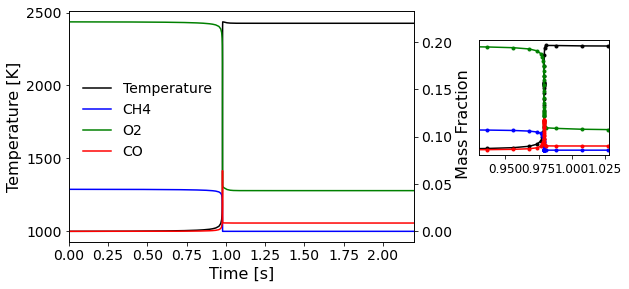

In [20]:
info={}
info['label1'] = {'label':'Temperature','units':' [K]'}
info['label2'] = {'label': 'CH4','units':' Mass Fraction'}
info['label3'] = {'label': 'O2','units':'  Mass Fraction'}
info['label4'] = {'label': 'CO','units':'  Mass Fraction'}
info['loc_x'] = 0.45
info['loc_y'] = 0.75
info['xlim'] = [0,1]

info['inset_x1'] = 0.55 + 0.5 
info['inset_y1'] = 0.4
info['inset_x2'] = 0.3 
info['inset_y2'] = 0.4

spNumber = 0
info['xlim2'] = [IgnTime[spNumber]*0.95,IgnTime[spNumber]*1.05]
info['xlim'] = [0,time_simulation[-1,spNumber]]

plt.figure()
x  = time_simulation[:,spNumber]
y1 = solution[:,spNumber, T_indx]
y2 = solution[:,spNumber, CH4_indx]
y3 = solution[:,spNumber, O2_indx]
y4 = solution[:,spNumber, CO_indx]
helper.makefigure(x, y1, y2, y3, y4, info, fs_label=16, fs_tick=14)

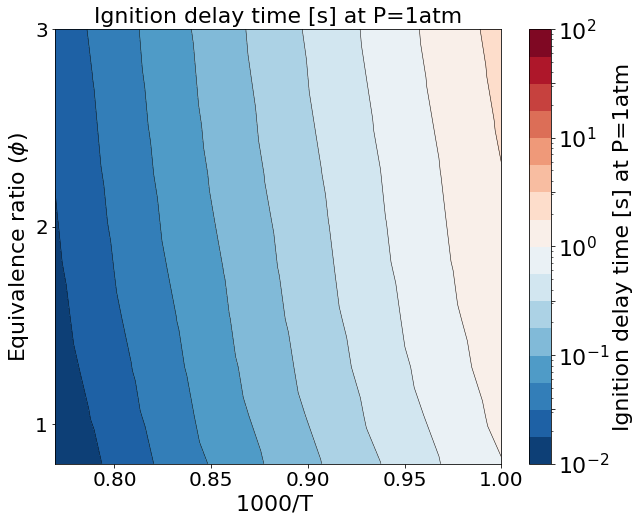

In [21]:
dirOutput = ''
Np = np.where(IgnTime>0)[0]
x = 1000./sample[Np,0]
Yo2 = sample[Np,3]
z = IgnTime[Np]
name_value =  'Ignition delay time [s] at P=1atm'
helper.plotResults(x, phi[Np], z,name_value, y_label_name='Equivalence ratio ($\phi$)',
            xtickvalues=[0.8, 0.85, 0.9, 0.95, 1],ytickvalues=[1,2,3])

Finalize Kokkos. This deletes the TChem object and the data stored as Kokkos views

In [ ]:
del(tchem)

In [22]:
pytchem.finalize()